# Investigating Additional Operational States

We require an investigation into alternative modes of operation of the compressor system. Main variables of interest are the boundary conditions that are used in the simulator model. 

* Inlet pressure (23-PT-92504): 3 barg
* Inlet temperature (23-TT-92504): 37.6 C
* Outlet pressure (transmitters not available, used 23-PT-92536 – 23-PDT-92602 – 0.1 (assumed additional pressure loss)): 12 barg
* Inlet Cooling Pressure (45-PT-93288, measurement not available, assumed) : 7.69 barg
* Inlet Cooling Temperature (45-TT-92606): 16.8 C
* Outlet Cooling Pressure (45-PT-92608): 5.05 barg

 

Controlled variable:

* Gas temp. out of coolers (23-TT-92604A): 34.73 C


## Setup

Retrieving requisite data from CDF. 

In [304]:
from cognite.client import CogniteClient
import os
import pandas as pd

client = CogniteClient()



/home/keepfloyding/.local/lib/python3.9/site-packages/cognite/client/_cognite_client.py:81: UserWarning: You are using version 2.37.1 of the SDK, however version 2.38.3 is available. Upgrade or set the environment variable 'COGNITE_DISABLE_PYPI_VERSION_CHECK' to suppress this warning.
  self._config = ClientConfig(
<ipython-input-304-ae8a4f502d42>:6: UserWarning: Authenticated towards inferred project 'publicdata'. Pass project to the CogniteClient constructor or set the environment variable 'COGNITE_PROJECT' to suppress this warning.
  client = CogniteClient(api_key=api_key, client_name='public-data-user')


In [305]:
# Retrieve data from CDF
ts_list = client.time_series.list(limit=-1)
ts_map = {ts.external_id: f"{ts.name}_{ts.unit}_{ts.description}; " for ts in ts_list if not ts.is_string }


In [306]:
tags = ['23-PT-92504', '23-TIC-92504:Z.X', '23-PT-92536', '23-PDT-92602','45-PT-93288','45-TT-92606','45-PT-92608','23-TT-92604A']

len(tags)

8

In [307]:
store={}
for key, val in ts_map.items():
    for tag in tags:
        if tag in val:
            store[key]= val
            continue

In [308]:
ts_list[0].first()

,value
2012-10-08 21:37:20.495,-0.103933


In [309]:
start_date = pd.to_datetime('2013-01-01')
end_date = 'now'


df = client.datapoints.retrieve_dataframe(start=start_date, end=end_date, external_id=list(store.keys()), aggregates=['average'], granularity='1h', include_aggregate_name=False)
df_cdf = df.rename(columns=store)

df_cdf.head()

,VAL_23-PT-92504:X.Value_None_PH 1stStgSuctCool Gas Out;,VAL_23-PT-92536:X.Value_bar_PH 1stStgComp Discharge;,VAL_45-TT-92606:X.Value_None_PH 1stStgDiscClr CoolMed Sply;,VAL_23-PDT-92602:X.Value_None_PH 1st Stg Disch Gas Coolers;,VAL_45-PT-92608:X.Value_None_PH 1stStgDiscCool CM Out;,VAL_23-TIC-92504:Z.X.Value_degC_PH 1stStgSuctCool Gas Out Measured Value;,VAL_23-TT-92604A:X.Value_degC_PH 1stStgDiscCool Gas Out Output;
2013-01-01 00:00:00,0.943041,0.921259,8.069841,0.001284,2.352663,7.966558,NaN
2013-01-01 01:00:00,0.941130,0.921253,7.959869,0.001305,2.352553,7.892904,NaN
2013-01-01 02:00:00,0.939474,0.921278,7.873731,0.001316,2.352564,7.825687,NaN
2013-01-01 03:00:00,0.937584,NaN,7.770483,0.001316,2.352379,7.712587,NaN
2013-01-01 04:00:00,0.935584,0.915320,7.642116,0.001315,2.352065,7.553171,NaN


In [310]:
# Deriving the outlet pressure
df_cdf['outlet_pressure_bar'] = df_cdf.filter(regex='23-PT-92536')-df_cdf.filter(regex='23-PDT-92602').values - 0.1

In [311]:
# Drop the not needed ones
cols_to_drop = df_cdf.filter(regex='(23-PT-92536)|(23-PDT-92602)').columns

df_cdf = df_cdf.drop(cols_to_drop,axis=1)

## Long term variable trends

Smoothing the lines and looking at long term trends. 


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

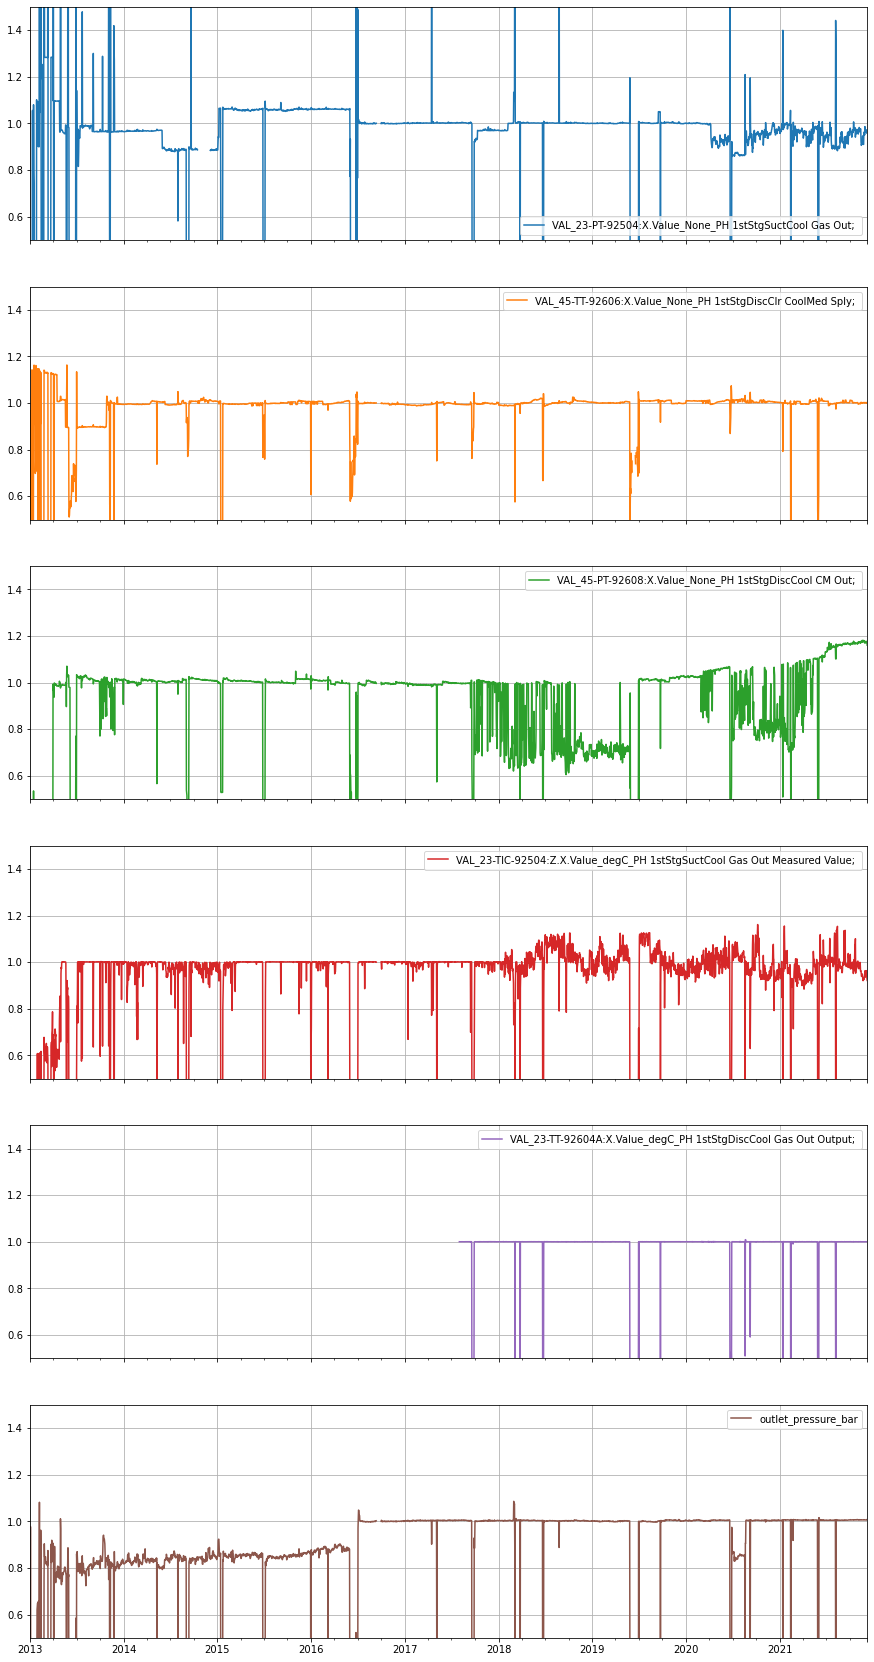

In [312]:
import matplotlib.pyplot as plt

# Looking at long term trends

tmp = df_cdf.resample('1D').median()
tmp = tmp/tmp.median()
tmp.plot(figsize=(15,30), subplots=True,grid=True, ylim=(0.5,1.5))



VAL_23-PT-92504:X.Value_None_PH 1stStgSuctCool Gas Out; : 0.04
VAL_45-TT-92606:X.Value_None_PH 1stStgDiscClr CoolMed Sply; : 0.01
VAL_45-PT-92608:X.Value_None_PH 1stStgDiscCool CM Out; : 0.11
VAL_23-TIC-92504:Z.X.Value_degC_PH 1stStgSuctCool Gas Out Measured Value; : 0.03
VAL_23-TT-92604A:X.Value_degC_PH 1stStgDiscCool Gas Out Output; : 0.0
outlet_pressure_bar: 0.08


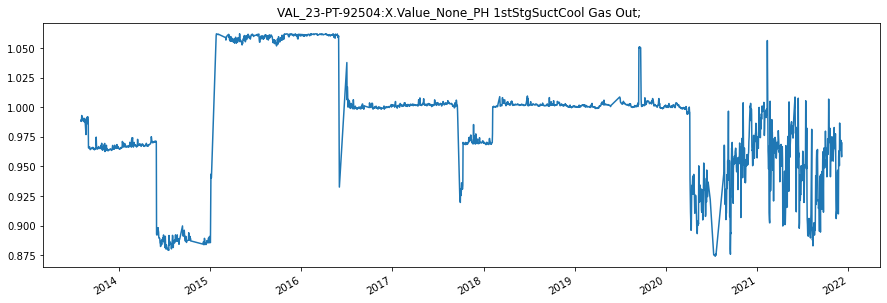

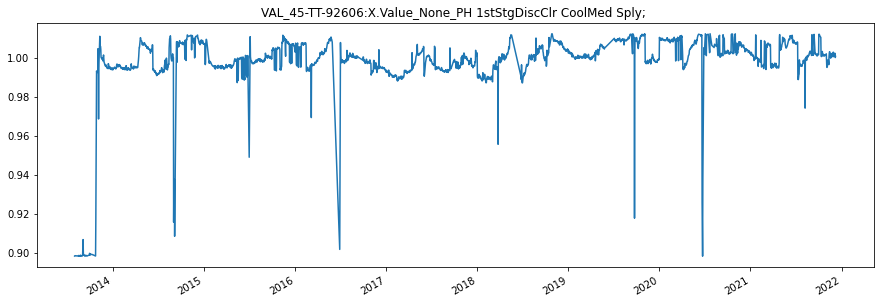

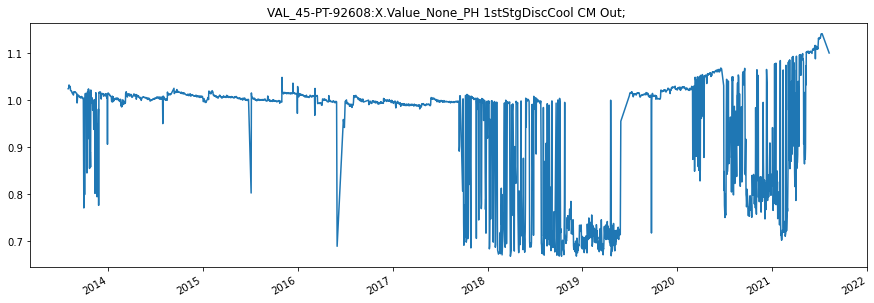

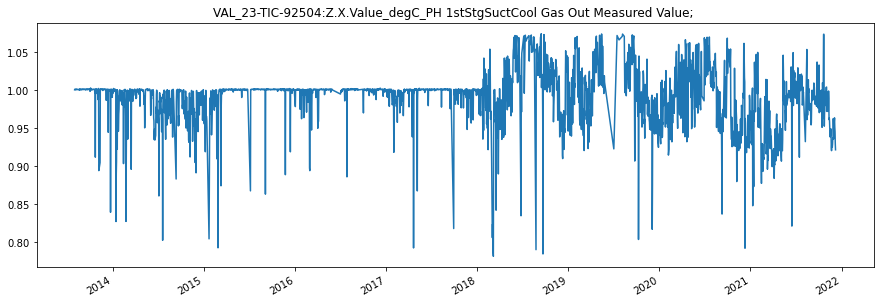

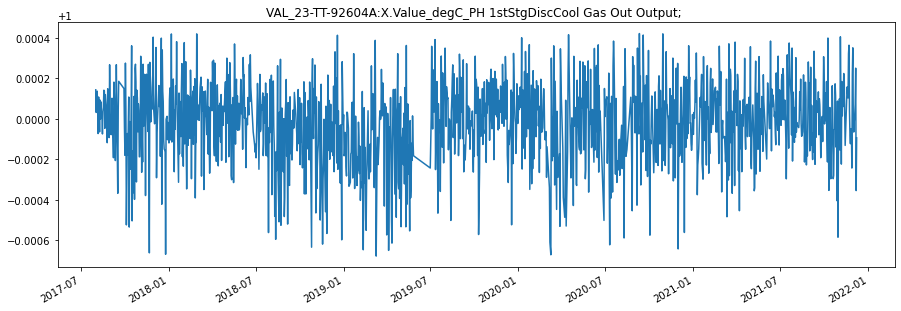

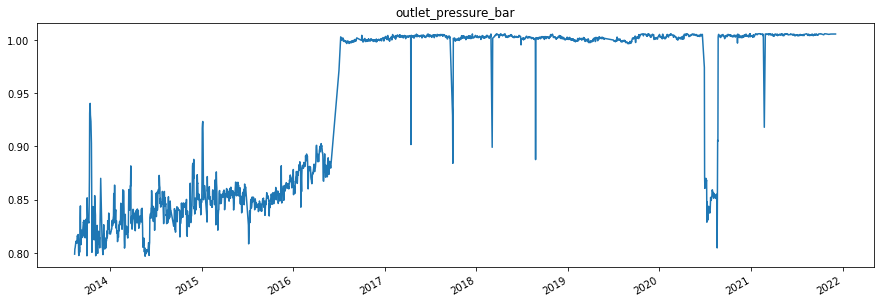

In [313]:
# Removing obvious outliers with quantiles (also diregarding the noise of the start-up state)

for col in tmp:
    plt.figure()
    tmp_2 = tmp[col].loc[pd.to_datetime('2013-08-01'):]
    filtered = tmp_2[(tmp_2>tmp_2.quantile(0.05))&(tmp_2<tmp_2.quantile(0.95))]
    filtered.plot(figsize=(15,5))
    print(f'{col}: {filtered.std().round(2)}')
    plt.title(col)

### Observations

* H1 2013 period can be dismissed as it has a lot of noise (likely due to start-up of machinery)
* Largest deviations occur as follows:
    * Pressure of CM out (norm. std of 0.11)
    * Outlet pressure (norm. std of 0.08)
    * Inlet pressure (norm. std of 0.04)
    * Temperature In (norm std of 0.03)
* Data for Temperature of gas output starts only from mid 2016; but since it is relatively constant, we can set it to be the same value.
* Step changes in the inlet pressure can be seen which could point to alternative operating regions. 
* Pressure of CM has low effect on simulation result so we can ignore
* Outlet pressure has 2 radically different modes of operation; can check both of those scenarios
* Early 2020 sees pressure output of suction cooler oscillating more clearly (likely due to opening of anti-surge valve)
* Temperature control of Gas Out of suction cooler is more erratic from 2018 onwards.


## Baseline noise level of sensors

Check the baseline noise level of the sensors.

In [314]:
# Checking the average rolling variance over a 12 hour period
start_date = pd.to_datetime('2014-01-01')
end_date = start_date+ pd.Timedelta(days=1)
df = client.datapoints.retrieve_dataframe(start=start_date, end=end_date, external_id=list(store.keys()), aggregates=['average'], granularity='1s', include_aggregate_name=False)
df_gran = df.rename(columns=store)


<AxesSubplot:>

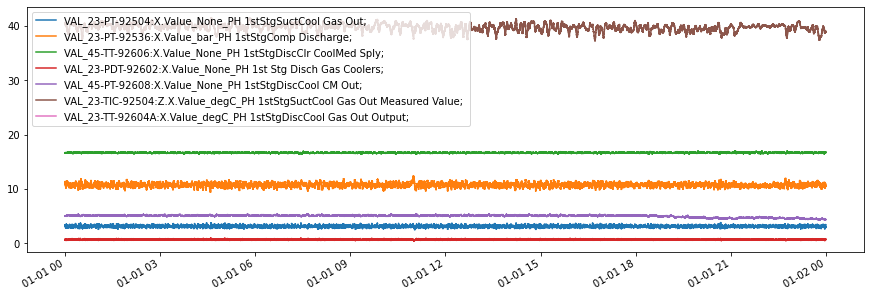

In [315]:
df_gran.plot(figsize=(15,5))

In [316]:
# 1 sec granularity over a day of constant operation

df_gran.max()-df_gran.median()

VAL_23-PT-92504:X.Value_None_PH 1stStgSuctCool Gas Out;                       0.661993
VAL_23-PT-92536:X.Value_bar_PH 1stStgComp Discharge;                          1.615875
VAL_45-TT-92606:X.Value_None_PH 1stStgDiscClr CoolMed Sply;                   0.276513
VAL_23-PDT-92602:X.Value_None_PH 1st Stg Disch Gas Coolers;                   0.249891
VAL_45-PT-92608:X.Value_None_PH 1stStgDiscCool CM Out;                        0.329280
VAL_23-TIC-92504:Z.X.Value_degC_PH 1stStgSuctCool Gas Out Measured Value;     1.699141
VAL_23-TT-92604A:X.Value_degC_PH 1stStgDiscCool Gas Out Output;                    NaN
dtype: float64

<AxesSubplot:>

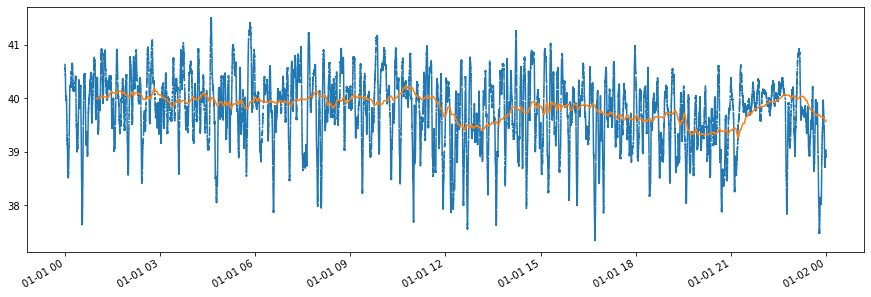

In [317]:
tmp = df_gran['VAL_23-TIC-92504:Z.X.Value_degC_PH 1stStgSuctCool Gas Out Measured Value; ']

tmp.plot(figsize=(15,5))
tmp.fillna(method='ffill').rolling(3600).median().plot()


<AxesSubplot:>

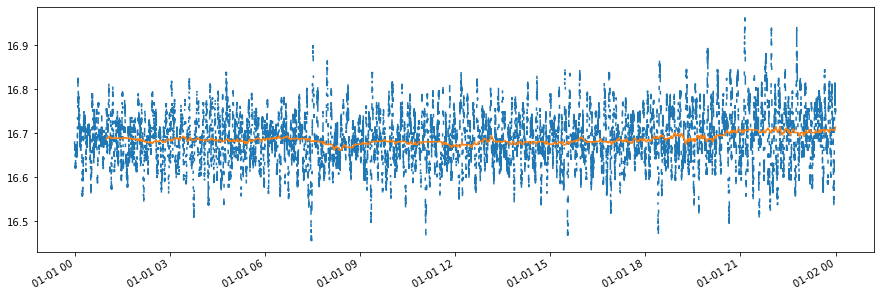

In [318]:
tmp = df_gran['VAL_45-TT-92606:X.Value_None_PH 1stStgDiscClr CoolMed Sply; ']

tmp.plot(figsize=(15,5))
tmp.fillna(method='ffill').rolling(3600).median().plot()


<AxesSubplot:>

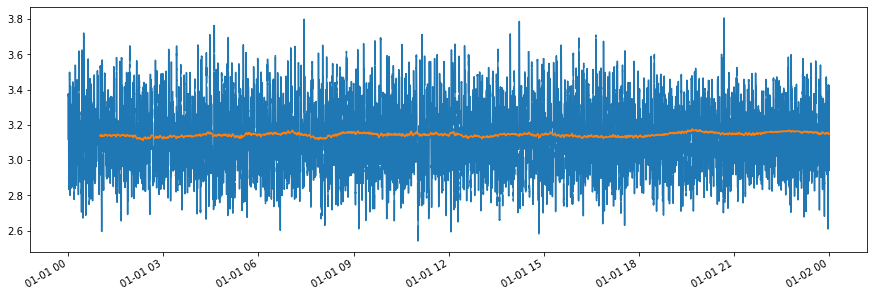

In [319]:
tmp = df_gran['VAL_23-PT-92504:X.Value_None_PH 1stStgSuctCool Gas Out; ']

tmp.plot(figsize=(15,5))
tmp.fillna(method='ffill').rolling(3600).median().plot()


In [320]:
# 1 hour granularity over a day of constant operation
(df_gran.resample('1H').mean().max()-df_gran.resample('1H').mean().median())

VAL_23-PT-92504:X.Value_None_PH 1stStgSuctCool Gas Out;                       0.014141
VAL_23-PT-92536:X.Value_bar_PH 1stStgComp Discharge;                          0.055876
VAL_45-TT-92606:X.Value_None_PH 1stStgDiscClr CoolMed Sply;                   0.026791
VAL_23-PDT-92602:X.Value_None_PH 1st Stg Disch Gas Coolers;                   0.017426
VAL_45-PT-92608:X.Value_None_PH 1stStgDiscCool CM Out;                        0.013737
VAL_23-TIC-92504:Z.X.Value_degC_PH 1stStgSuctCool Gas Out Measured Value;     0.266761
VAL_23-TT-92604A:X.Value_degC_PH 1stStgDiscCool Gas Out Output;                    NaN
dtype: float64

### Observations

* High variablility encountered for 1 second data (>0.6 bar for pressure sensors and 1.7 C for one temperature sensor)
* 1 hour data has low variability (<0.1 bar for pressure sensors and <0.3 C for temperature)

Looking for operating modes that have greater variability than the threshold found above for 1 hour data

## Identifying different operating modes

Observations of previous

* Inlet pressure has various steady state changes over the historical record (~6). 
* Outlet pressure has ~2-3 noticeable states that should be covered by the regions identified above (aside from single drop identified in mid 2020)
* Potentially can also include a big peak in the inlet temparature (regions of 1.05 and 0.9)

In [321]:
# Function for outlier removal and s
from scipy.signal import savgol_filter

def outlier_removal_and_smoother(df, col, polyorder=3, window_length=5):
    tmp = df[col]
    
    # remove start-up perido
    tmp = tmp.loc[pd.to_datetime('2013-09-01'):]
    
    # remove outliers
    tmp = tmp[(tmp>tmp.quantile(0.05))&(tmp<tmp.quantile(0.95))]
    
    # SG smoother
    data = tmp.values
    index=tmp.index
    return pd.Series(savgol_filter(data, window_length=window_length, polyorder=polyorder), index=index)

    

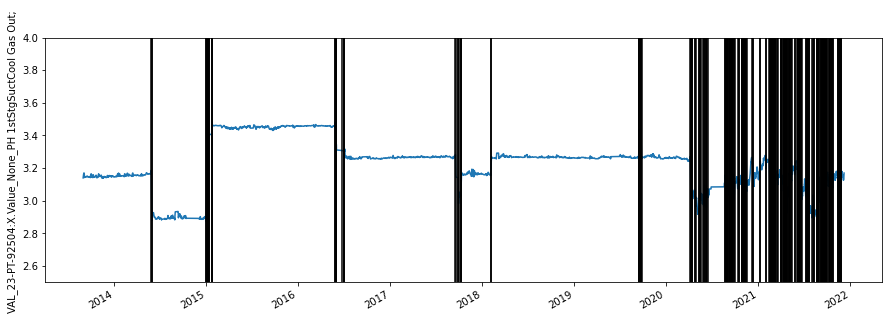

In [322]:
col = df_cdf.filter(regex='23-PT-92504').columns[0]
tmp = outlier_removal_and_smoother(df_cdf, col, window_length=101, polyorder=2)

#df_cdf[col].plot()
tmp.plot(figsize=(15,5))
plt.ylim([2.5,4.0])
plt.ylabel(col)

# break points
index = tmp[(tmp.rolling(24).max()-tmp.rolling(24).mean())>0.02].index
days = set([item.date() for item in index])
for item in days:
    plt.axvline(item,color='k')
    

In [323]:
intervals = pd.Series(sorted(days))

print(tmp.index[0])
print(intervals[0])

for day in intervals[intervals.diff()>pd.Timedelta(days=14)].values:
    print(day)

2013-09-01 00:00:00
2014-05-30
2015-01-02
2016-05-28
2016-06-23
2017-09-18
2018-02-06
2019-09-15
2020-04-07
2020-08-22
2020-12-09
2021-01-08
2021-01-31
2021-07-10
2021-11-13


### Observations

From the above, we can take a day in the following time period (I'm choosing half way in between):
* 2013-09-01 - 2014-05-30
* 2014-05-30 - 2015-01-02
* 2015-01-02 - 2016-05-29
* 2016-05-28 - 2016-06-23
* 2016-06-23 - 2017-09-18
* 2017-09-18 - 2018-02-06
* 2017-09-15 - 2020-04-07

The later periods are affected by the movement of the anti-surge valve, so these will require closer analysis



## Outlet Pressure Analysis

Checking the values of the outlet pressure

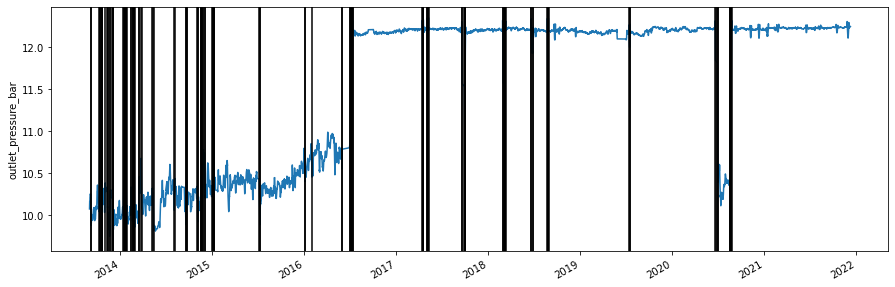

In [324]:
col = df_cdf.filter(regex='outlet').columns[0]
tmp = outlier_removal_and_smoother(df_cdf, col, window_length=101, polyorder=2)
tmp.plot(figsize=(15,5))
plt.ylabel(col)

index = tmp[(tmp.rolling(24).max()-tmp.rolling(24).mean())>0.1].index
days = set([item.date() for item in index])
for item in days:
    plt.axvline(item,color='k')

## Find all relevant variables

Look at each time period and grab the values

* 2013-09-01 - 2014-05-30
* 2014-05-30 - 2015-01-02
* 2015-01-02 - 2016-05-29
* 2016-05-28 - 2016-06-23
* 2016-06-23 - 2017-09-18
* 2017-09-18 - 2018-02-06
* 2017-09-15 - 2020-04-07

In [325]:
def plot_and_grab_all_values(df, start, end, ratio=0.5):
    
    
    interval = (end-start)*ratio
    new_start = (start+interval).floor('1h')
    new_end = new_start+pd.Timedelta(hours=1)
    plot_end = new_start+pd.Timedelta(days=1)
    
    print(new_start)
    
    df.loc[new_start:plot_end].plot(subplots=True, figsize=(15,20))
    
    res = df.loc[new_start:new_end].mean().round(2)
    print(res)
    res.name = new_start
    return res
    
    

In [326]:
store=[]

2013-11-21 07:00:00
VAL_23-PT-92504:X.Value_None_PH 1stStgSuctCool Gas Out;                        3.14
VAL_45-TT-92606:X.Value_None_PH 1stStgDiscClr CoolMed Sply;                   16.79
VAL_45-PT-92608:X.Value_None_PH 1stStgDiscCool CM Out;                         4.12
VAL_23-TIC-92504:Z.X.Value_degC_PH 1stStgSuctCool Gas Out Measured Value;     40.10
VAL_23-TT-92604A:X.Value_degC_PH 1stStgDiscCool Gas Out Output;                 NaN
outlet_pressure_bar                                                            9.82
dtype: float64


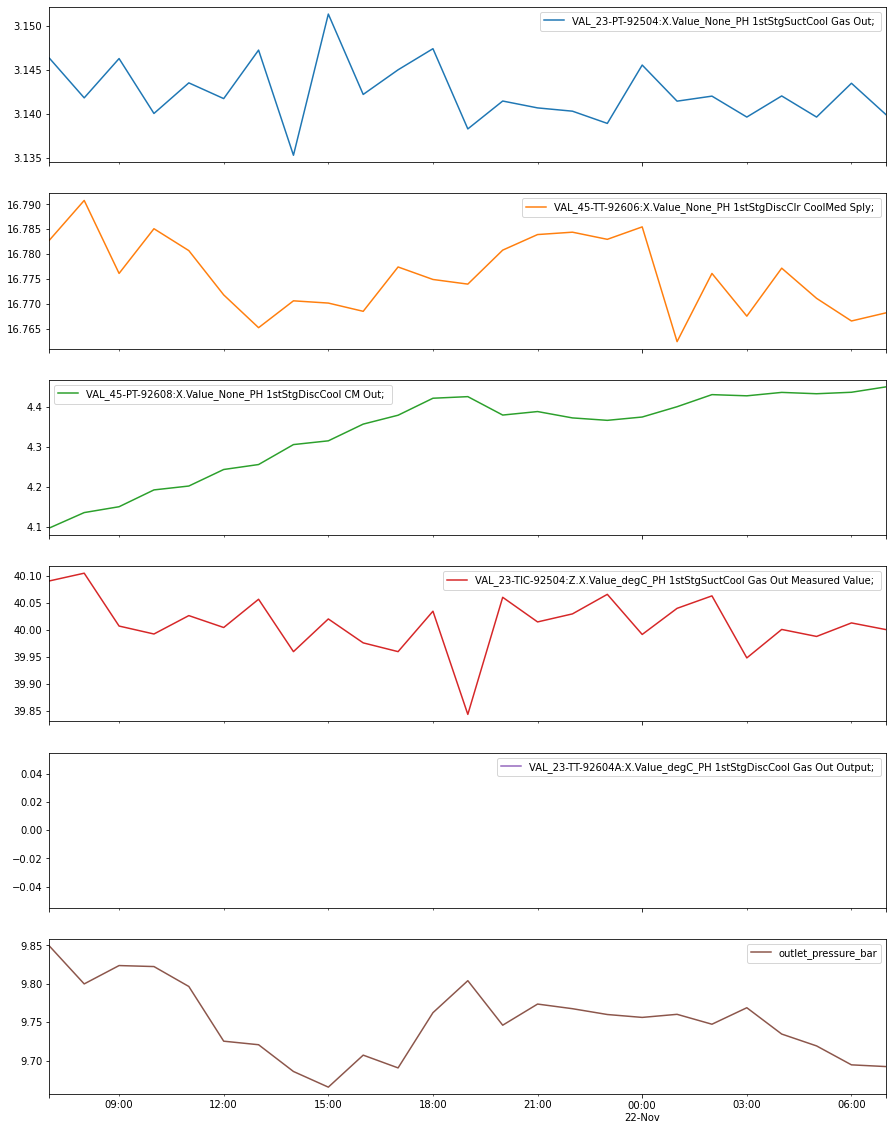

In [327]:
res = plot_and_grab_all_values(df_cdf, pd.to_datetime('2013-09-01'), pd.to_datetime('2014-05-30'), ratio=0.3)
store.append(res)

2014-07-13 09:00:00
VAL_23-PT-92504:X.Value_None_PH 1stStgSuctCool Gas Out;                        2.87
VAL_45-TT-92606:X.Value_None_PH 1stStgDiscClr CoolMed Sply;                   16.69
VAL_45-PT-92608:X.Value_None_PH 1stStgDiscCool CM Out;                         5.08
VAL_23-TIC-92504:Z.X.Value_degC_PH 1stStgSuctCool Gas Out Measured Value;     39.63
VAL_23-TT-92604A:X.Value_degC_PH 1stStgDiscCool Gas Out Output;                 NaN
outlet_pressure_bar                                                           10.51
dtype: float64


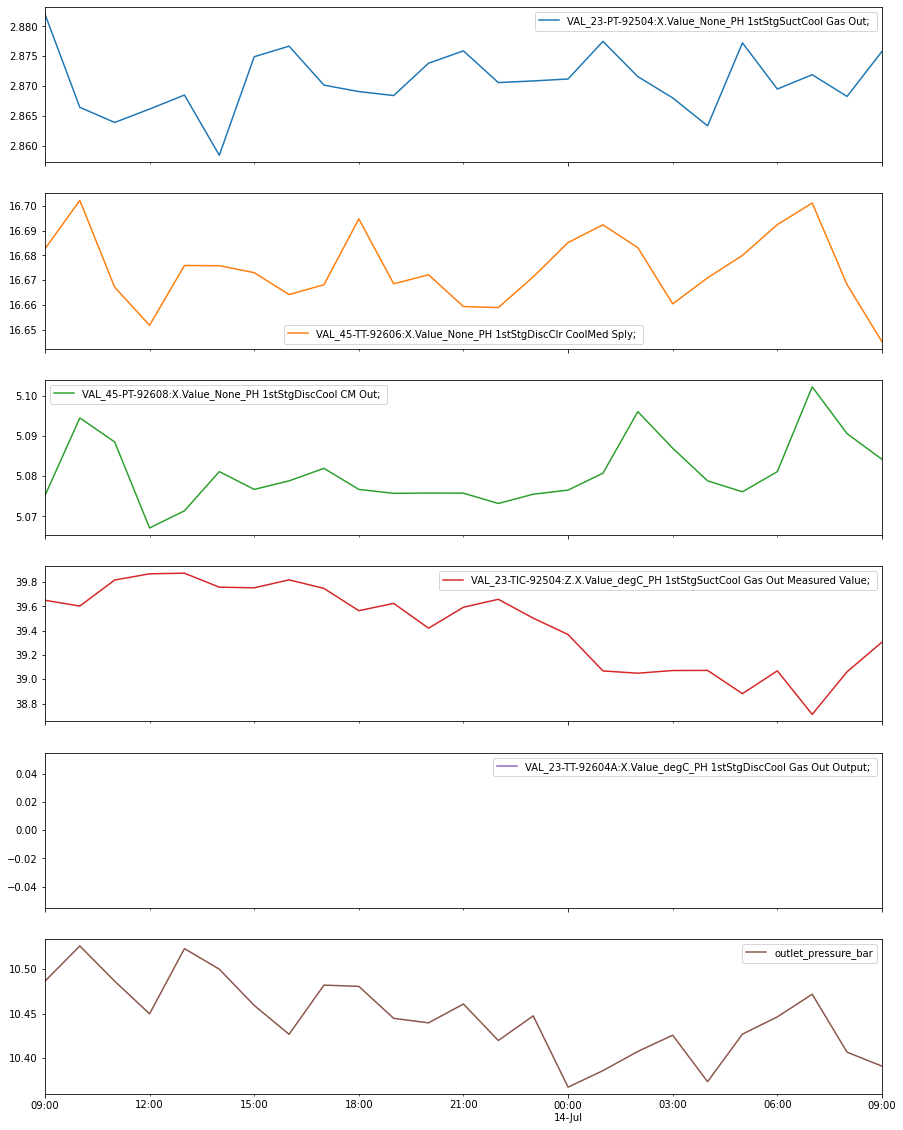

In [328]:
res = plot_and_grab_all_values(df_cdf, pd.to_datetime('2014-05-31'), pd.to_datetime('2015-01-03'), ratio=0.2)
store.append(res)

2015-04-14 14:00:00
VAL_23-PT-92504:X.Value_None_PH 1stStgSuctCool Gas Out;                        3.44
VAL_45-TT-92606:X.Value_None_PH 1stStgDiscClr CoolMed Sply;                   16.73
VAL_45-PT-92608:X.Value_None_PH 1stStgDiscCool CM Out;                         5.09
VAL_23-TIC-92504:Z.X.Value_degC_PH 1stStgSuctCool Gas Out Measured Value;     40.05
VAL_23-TT-92604A:X.Value_degC_PH 1stStgDiscCool Gas Out Output;                 NaN
outlet_pressure_bar                                                           10.35
dtype: float64


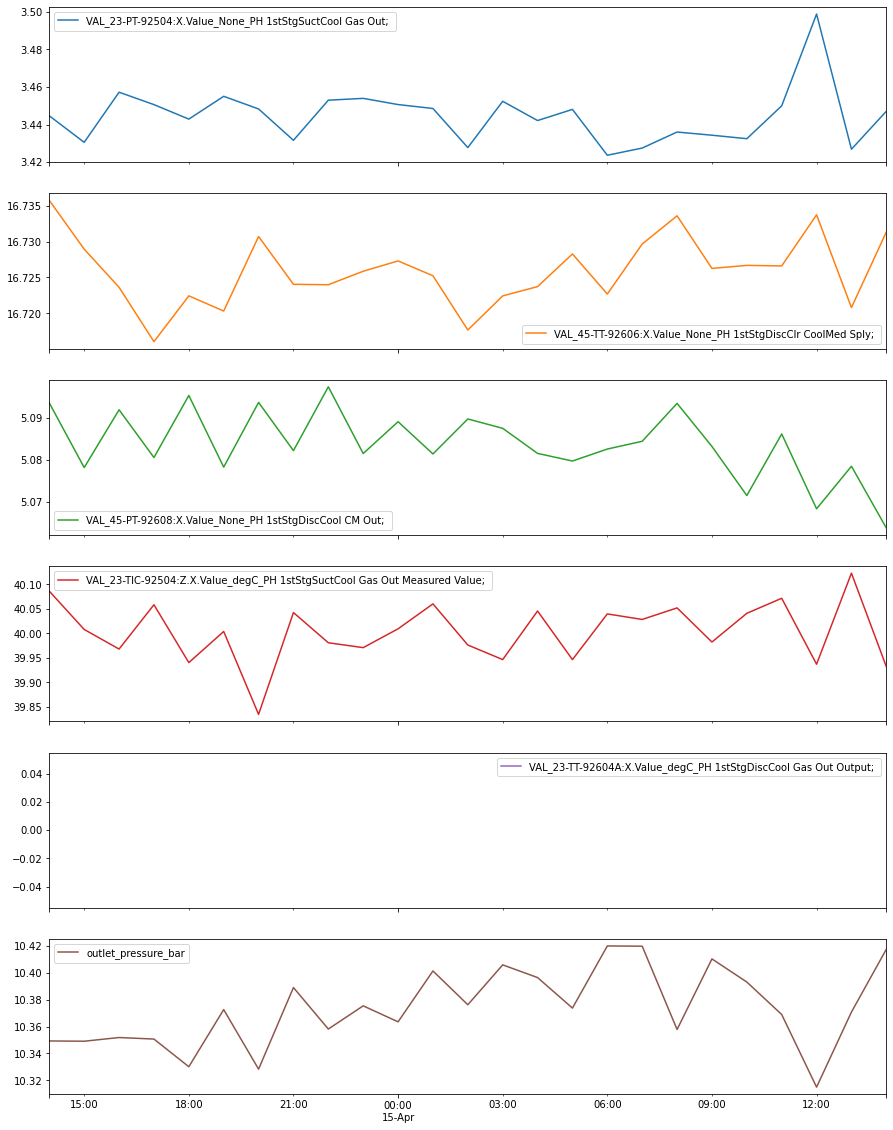

In [329]:
# 2015-01-02 - 2016-05-29

res = plot_and_grab_all_values(df_cdf, pd.to_datetime('2015-01-02'), pd.to_datetime('2016-05-29'), ratio=0.2)
store.append(res)

2017-07-12 04:00:00
VAL_23-PT-92504:X.Value_None_PH 1stStgSuctCool Gas Out;                        3.27
VAL_45-TT-92606:X.Value_None_PH 1stStgDiscClr CoolMed Sply;                   16.72
VAL_45-PT-92608:X.Value_None_PH 1stStgDiscCool CM Out;                         5.03
VAL_23-TIC-92504:Z.X.Value_degC_PH 1stStgSuctCool Gas Out Measured Value;     39.94
VAL_23-TT-92604A:X.Value_degC_PH 1stStgDiscCool Gas Out Output;                 NaN
outlet_pressure_bar                                                           12.24
dtype: float64


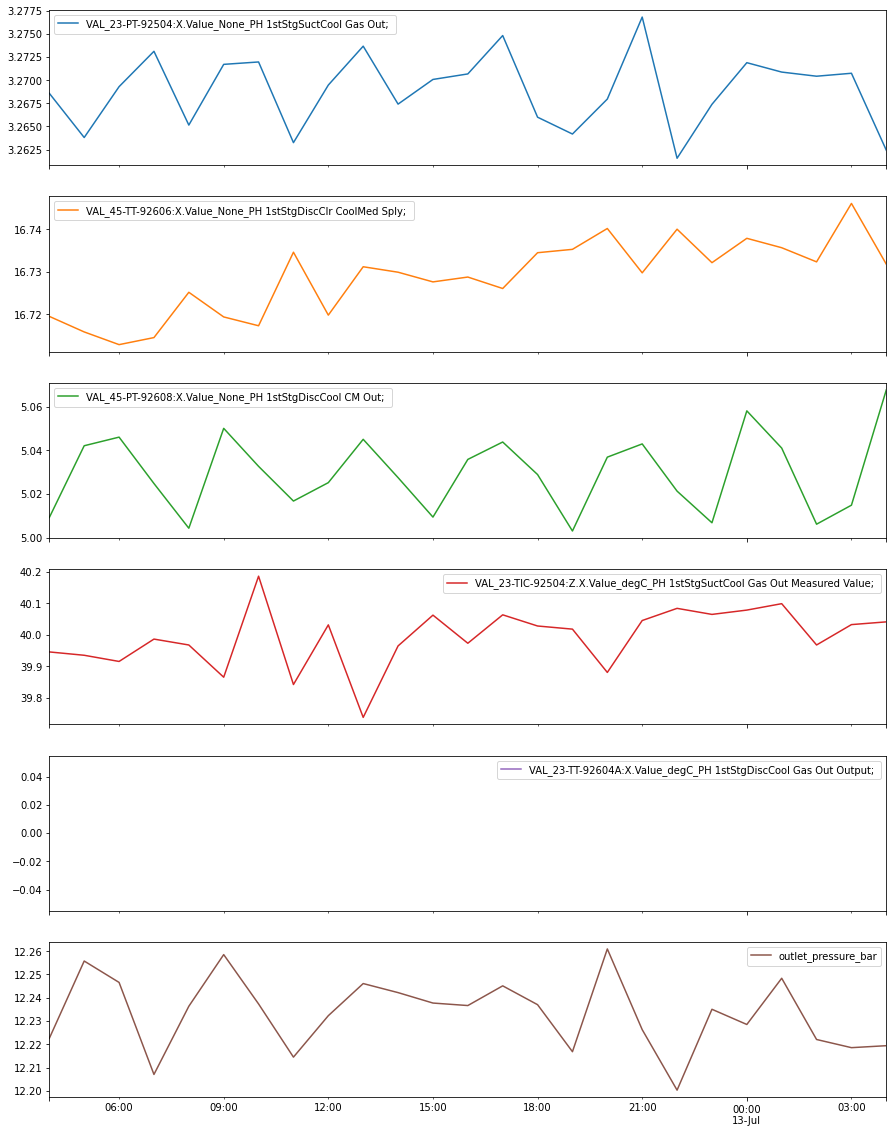

In [330]:
# 2016-06-23 - 2017-09-18

res = plot_and_grab_all_values(df_cdf, pd.to_datetime('2016-06-23'), pd.to_datetime('2017-09-18'), ratio=0.85)
store.append(res)

2018-01-08 19:00:00
VAL_23-PT-92504:X.Value_None_PH 1stStgSuctCool Gas Out;                        3.16
VAL_45-TT-92606:X.Value_None_PH 1stStgDiscClr CoolMed Sply;                   16.65
VAL_45-PT-92608:X.Value_None_PH 1stStgDiscCool CM Out;                         3.36
VAL_23-TIC-92504:Z.X.Value_degC_PH 1stStgSuctCool Gas Out Measured Value;     38.66
VAL_23-TT-92604A:X.Value_degC_PH 1stStgDiscCool Gas Out Output;               34.98
outlet_pressure_bar                                                           12.22
dtype: float64


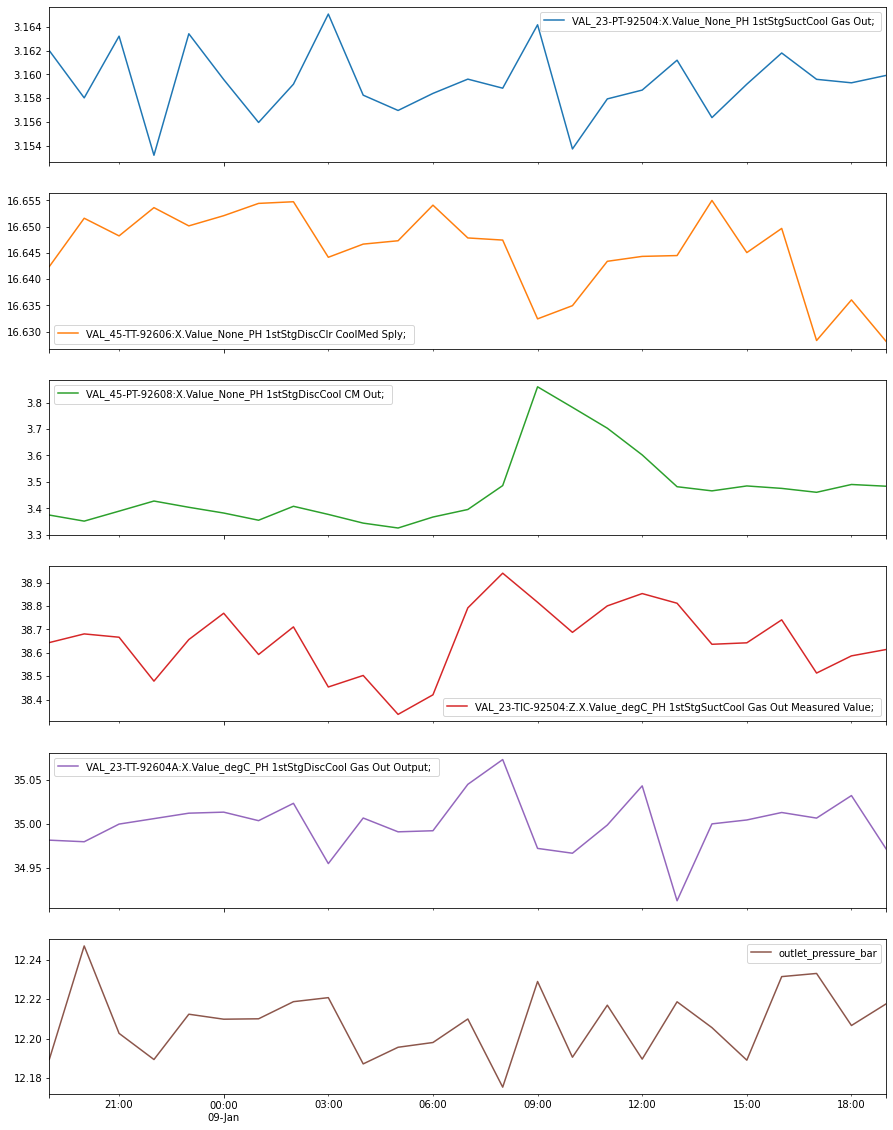

In [331]:
# 2017-09-18 - 2018-02-06

res = plot_and_grab_all_values(df_cdf, pd.to_datetime('2017-09-18'), pd.to_datetime('2018-02-06'), ratio=0.8)
store.append(res)

2018-12-26 12:00:00
VAL_23-PT-92504:X.Value_None_PH 1stStgSuctCool Gas Out;                        3.26
VAL_45-TT-92606:X.Value_None_PH 1stStgDiscClr CoolMed Sply;                   16.84
VAL_45-PT-92608:X.Value_None_PH 1stStgDiscCool CM Out;                         4.14
VAL_23-TIC-92504:Z.X.Value_degC_PH 1stStgSuctCool Gas Out Measured Value;     40.44
VAL_23-TT-92604A:X.Value_degC_PH 1stStgDiscCool Gas Out Output;               35.05
outlet_pressure_bar                                                           12.19
dtype: float64


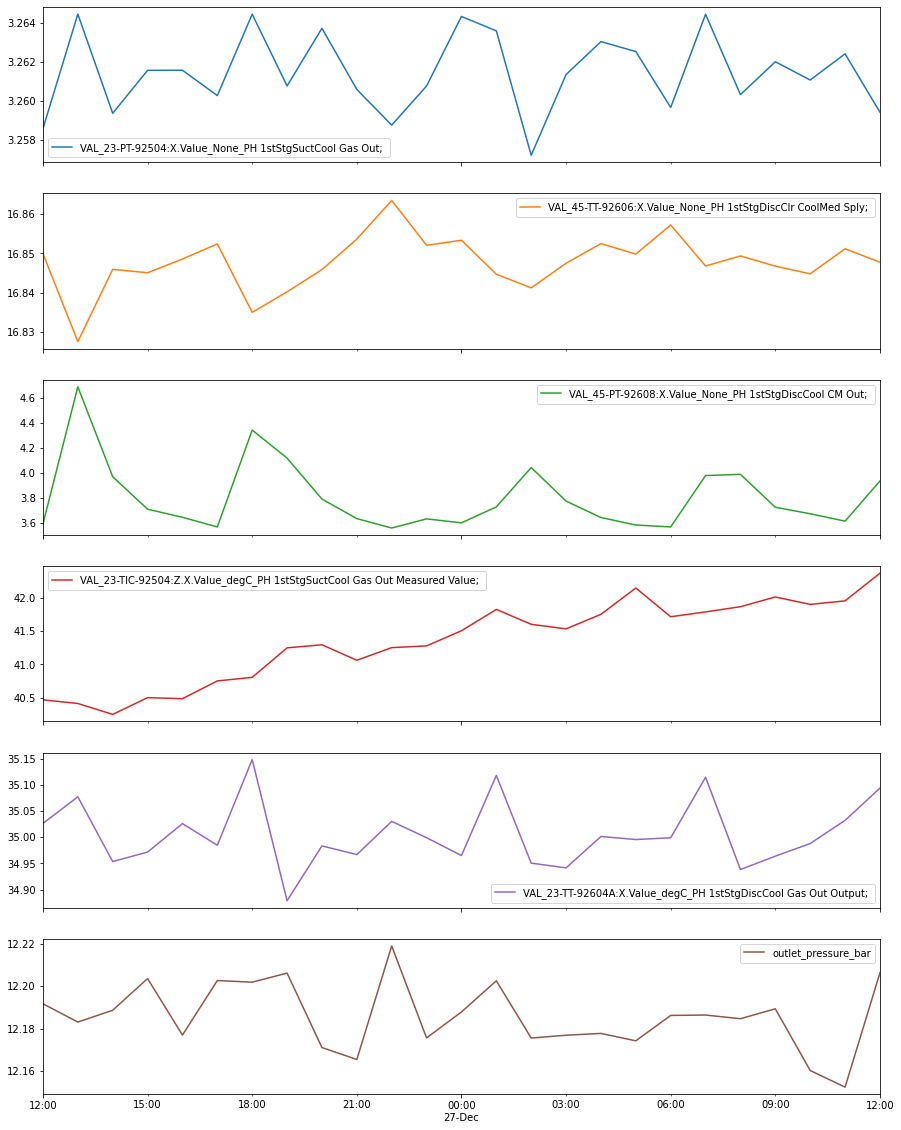

In [332]:
# 2017-09-15 - 2020-04-07

res = plot_and_grab_all_values(df_cdf, pd.to_datetime('2017-09-15'), pd.to_datetime('2020-04-07'), ratio=0.5)
store.append(res)

### Summary of variables

Below a summary for each time period (1 hour duration)

In [333]:
res = pd.concat(store,axis=1)
res.index = ['23-PT-92504', '45-TT-92606', '45-PT-92608', '23-TIC-92504', 'TT-92604A', 'Calc. Outlet Pressure']
res

,2013-11-21 07:00:00,2014-07-13 09:00:00,2015-04-14 14:00:00,2017-07-12 04:00:00,2018-01-08 19:00:00,2018-12-26 12:00:00
23-PT-92504,3.14,2.87,3.44,3.27,3.16,3.26
45-TT-92606,16.79,16.69,16.73,16.72,16.65,16.84
45-PT-92608,4.12,5.08,5.09,5.03,3.36,4.14
23-TIC-92504,40.10,39.63,40.05,39.94,38.66,40.44
TT-92604A,NaN,NaN,NaN,NaN,34.98,35.05
Calc. Outlet Pressure,9.82,10.51,10.35,12.24,12.22,12.19


In [334]:
res.to_csv('Valhall-operating-states.csv')